In [1]:
import pickle
import glob
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

In [2]:
def from_twist(twist):
    """Convert a 6D twist coordinate (shape (6,)) into a 3x3 rotation matrix
    and translation vector (shape (3,))."""
    r = twist[:3].reshape(3, 1)
    t = twist[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(r)
    return R, t

In [3]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

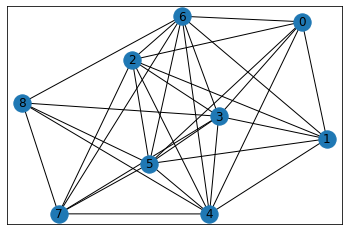

In [4]:
import networkx as nx

nx.draw_networkx(pose_graph, with_labels=True)#.edges
plt.show()

In [5]:
pose_graph[0][1]["num_matches"], pose_graph[1][2]["num_matches"], pose_graph[0][2]["num_matches"]

(362, 278, 250)

In [6]:
newest_node_id = 2
num_matches = [pose_graph[u][v]["num_matches"] for u, v in pose_graph.edges(newest_node_id)]
neighbors_keyframes = [node_id for _, node_id in sorted(pose_graph.edges(newest_node_id))]
print(newest_node_id)
print(neighbors_keyframes)
print(num_matches)

2
[0, 1, 3, 4, 5, 6, 7]
[278, 250, 357, 381, 258, 179, 66]


In [7]:
map_points.pts_3d.shape

(2998, 3)

In [8]:
map_points.idx.shape, map_points.pts_3d.shape, map_points.representative_orb.shape, len(map_points.observations)

((2998,), (2998, 3), (2998, 32), 2998)

In [9]:
Counter(sorted([len([v for v in ob.values() if v is not None]) for ob in map_points.observations]))

Counter({2: 1533, 3: 681, 4: 424, 5: 260, 6: 86, 7: 14})

In [10]:
Counter(sorted([len(ob) for ob in map_points.observations]))

Counter({2: 642, 3: 646, 4: 597, 5: 551, 6: 451, 7: 110, 9: 1})

In [11]:
np.where([len([v for v in ob.values() if v is not None]) == 6 for ob in map_points.observations])

(array([  57,   90,  219,  378,  392,  402,  417,  418,  426,  444,  599,
         611,  650,  685,  715,  755,  759,  773,  780,  806,  829,  888,
         911, 1013, 1017, 1021, 1033, 1034, 1035, 1056, 1062, 1079, 1089,
        1099, 1104, 1109, 1112, 1134, 1150, 1189, 1199, 1449, 1451, 1459,
        1468, 1474, 1487, 1505, 1509, 1515, 1516, 1518, 1523, 1535, 1540,
        1563, 1586, 1666, 1668, 1743, 1788, 1838, 1857, 1869, 1885, 1895,
        1904, 1924, 1936, 1987, 2009, 2020, 2021, 2029, 2069, 2082, 2174,
        2283, 2374, 2385, 2633, 2672, 2674, 2676, 2739, 2804]),)

Observing keyframes: [0, 1, 2, 3, 4, 5]
projected_pts 139 467
node_id 0
2643
kp [139. 467.]


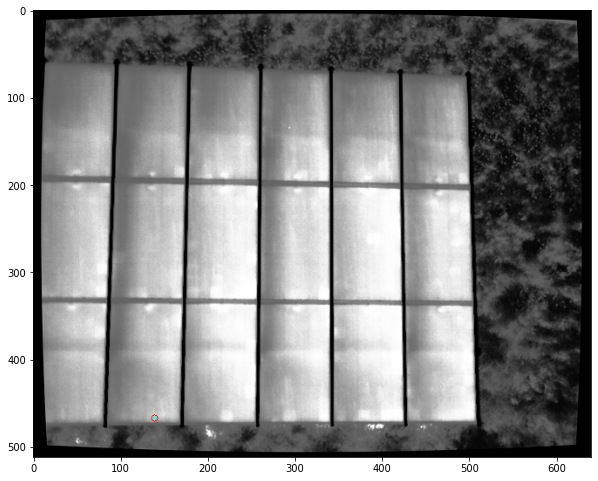

projected_pts 213 462
node_id 1
446
kp [214. 463.]


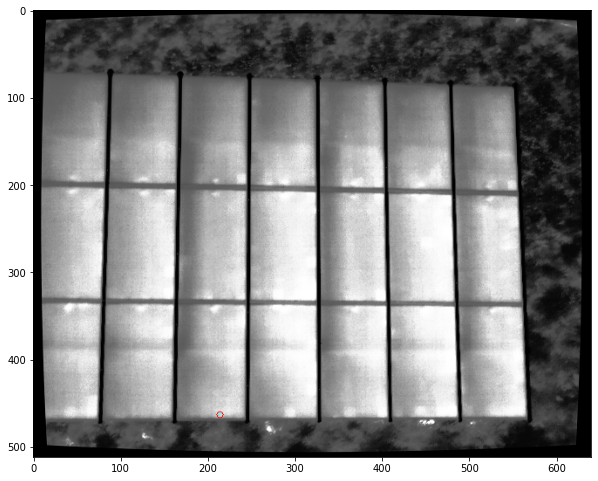

projected_pts 290 384
node_id 2
367
kp [291. 385.]


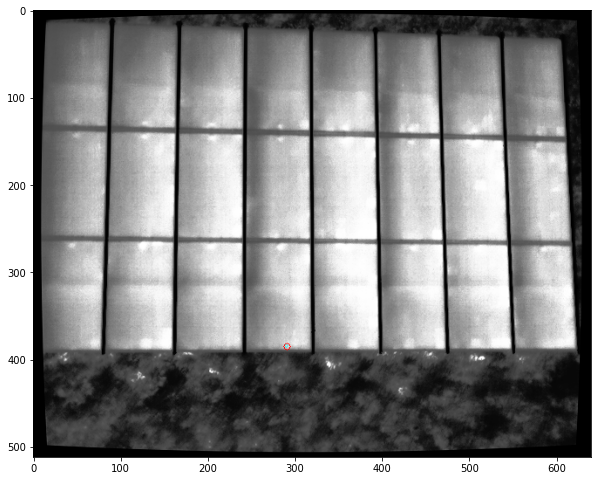

projected_pts 384 351
node_id 3
2623
kp [385. 352.]


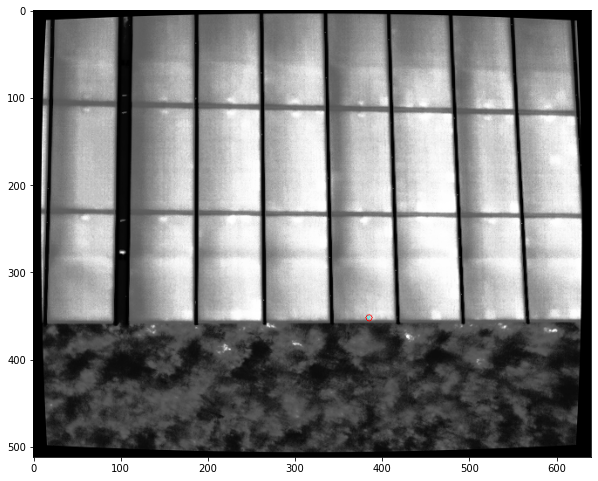

projected_pts 479 381
node_id 4
318
kp [486. 383.]


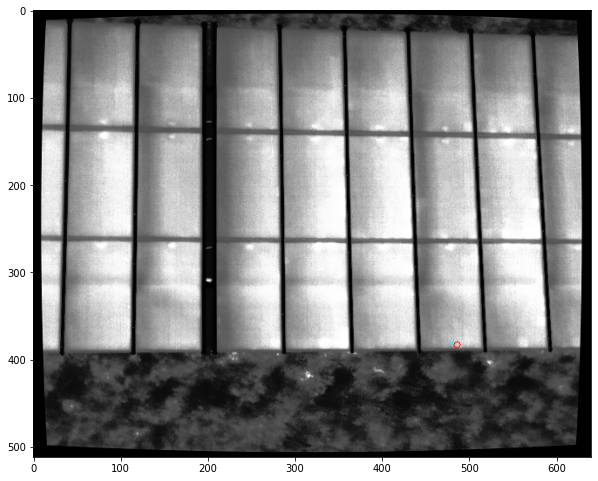

projected_pts 576 408
node_id 5
386
kp [589. 411.]


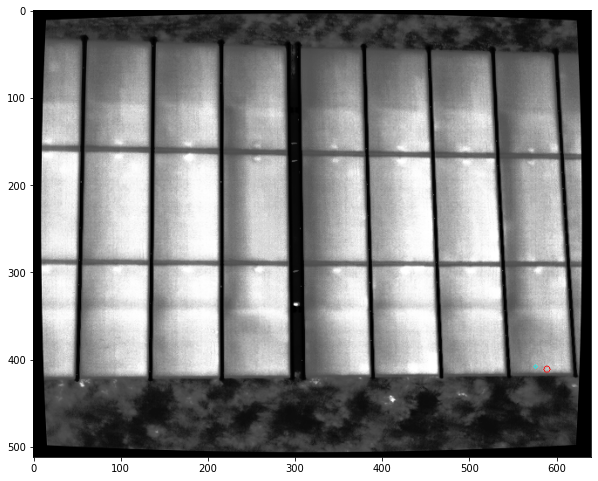

In [12]:
map_point_idx = 57  # all point sunder 514 work well

observing_keyframes = list(map_points.observations[map_point_idx].keys())
print("Observing keyframes:", observing_keyframes)

for node_id in sorted(pose_graph.nodes):
    if node_id not in observing_keyframes:
        continue
    #print(node_id)
    
    frame = pose_graph.nodes[node_id]["frame"]
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    # project map point into frame
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    t = -R.T.dot(t)
    R = R.T
    projected_pts, _ = cv2.projectPoints(map_points.pts_3d[map_point_idx, :], R, t, camera_matrix, None)
    print("projected_pts", int(projected_pts[0, 0, 0]), int(projected_pts[0, 0, 1]))
    frame = cv2.circle(frame, (int(projected_pts[0, 0, 0]), int(projected_pts[0, 0, 1])), 2, (255, 255, 0))
    
    
    # get keypoint associated to the selected map point
    #print(map_points.associated_kp_indices[map_point_idx])
    #i = observing_keyframes.index(node_id)
    print("node_id", node_id)
    kp_idx = map_points.observations[map_point_idx][node_id]
    print(kp_idx)
    
    if kp_idx is not None:
    
        kp = pose_graph.nodes[node_id]["kp"][kp_idx]
        print("kp", kp)

        frame = cv2.circle(frame, (int(kp[0]), int(kp[1])), 4, (0, 0, 255))

        fig = plt.figure()
        fig.set_size_inches(10, 10)
        plt.imshow(frame[:, :, ::-1])
        plt.show()